> # Enhanced Deep Residual Networks for Single Image Super-Resolution
#### Paper : https://arxiv.org/abs/1707.02921

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
AUTOTUNE = tf.data.AUTOTUNE

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os

# Data Agumentation

In [2]:
def flip_left_right(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))

def random_rotate(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rn), tf.image.rot90(hr_img, rn)

def random_crop(lr_img, hr_img, hr_crop_size=96, scale=4):
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_width = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_height = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_width = lr_width * scale
    hr_height = lr_height * scale

    lr_img_cropped = lr_img[lr_height:lr_height + lr_crop_size, lr_width:lr_width + lr_crop_size]
    hr_img_cropped = hr_img[hr_height:hr_height + hr_crop_size, hr_width:hr_width + hr_crop_size]

    return lr_img_cropped, hr_img_cropped

# Loading Data using tensorflow datasets

In [3]:
div2k_data = tfds.image.Div2k(config='bicubic_x4')
div2k_data.download_and_prepare()

2022-01-15 10:10:28.609148: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling div2k-train.tfrecord...:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling div2k-validation.tfrecord...:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


In [4]:
train = div2k_data.as_dataset(split='train',as_supervised=True)
train_cache = train.cache()

2022-01-15 10:15:50.114329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 10:15:50.222546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 10:15:50.223388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 10:15:50.226544: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
ds = train_cache

ds = ds.map(lambda lr, hr: random_crop(lr, hr, scale=4),num_parallel_calls=AUTOTUNE)
ds = ds.map(random_rotate,num_parallel_calls=AUTOTUNE)
ds = ds.map(flip_left_right,num_parallel_calls=AUTOTUNE)

ds = ds.batch(16)
ds = ds.repeat(None)
ds = ds.prefetch(buffer_size=AUTOTUNE)

In [6]:
lr, hr = next(iter(ds))

2022-01-15 10:15:53.427158: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-15 10:16:22.043799: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# High Resolution Images

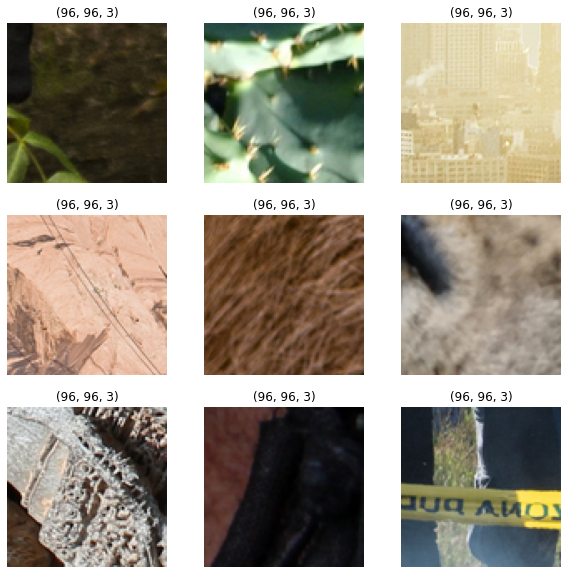

In [7]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(hr[i].numpy().astype('uint8'))
    plt.title(hr[i].shape)
    plt.axis("off")

# Low Resolution Images

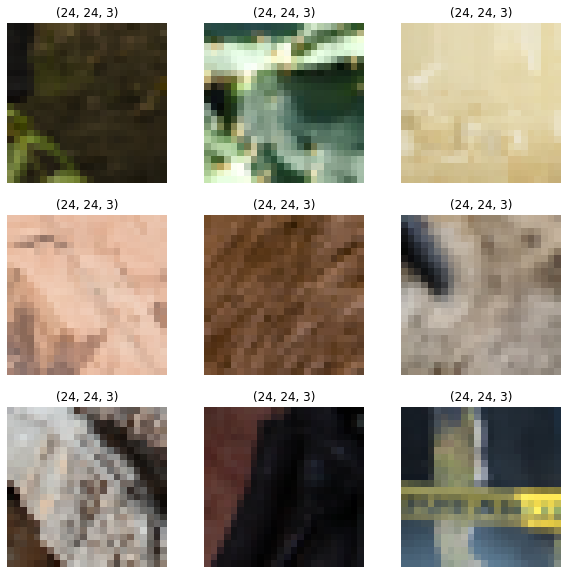

In [8]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lr[i].numpy().astype('uint8'))
    plt.title(lr[i].shape)
    plt.axis("off")

# Normalization and usefull functions

In [9]:
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

def normalize(x,rgb_mean=DIV2K_RGB_MEAN):
    return (x - rgb_mean) / 127.5

def denormalize(x,rgb_mean=DIV2K_RGB_MEAN):
    return (x * 127.5 )+ rgb_mean

def shuffle_pixels(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

def PSNR(sr, hr):
    psnr_value = tf.image.psnr(hr, sr, max_val=255)[0]
    return psnr_value

# Model Building

<img src = "https://miro.medium.com/max/1400/1*a1tQ4grku_ugTTe39IJzjA.png" width="500">

In [10]:
def ResBlock(inputs):
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
    x = tf.keras.layers.Add()([inputs, x])
    return x

In [11]:
def Upsampling(inputs, factor=2, **kwargs):
    x = tf.keras.layers.Conv2D(64 * (factor ** 2), 3, padding='same', **kwargs)(inputs)
    x = tf.keras.layers.Lambda(shuffle_pixels(scale=factor))(x)
    x = tf.keras.layers.Conv2D(64 * (factor ** 2), 3, padding='same', **kwargs)(x)
    x = tf.keras.layers.Lambda(shuffle_pixels(scale=factor))(x)
    return x

In [12]:
def EDSR():
    input_layer = tf.keras.layers.Input(shape=(None, None, 3))
    x = tf.keras.layers.Lambda(normalize)(input_layer)
    x = x_new = tf.keras.layers.Conv2D(64, 3, padding='same')(x)

    for _ in range(16):
        x_new = ResBlock(x_new)
        
    x_new = tf.keras.layers.Conv2D(64, 3, padding='same')(x_new)
    x = tf.keras.layers.Add()([x, x_new])

    x = Upsampling(x)
    x = tf.keras.layers.Conv2D(3, 3, padding='same')(x)
    output_layer = tf.keras.layers.Lambda(denormalize)(x)
    return tf.keras.models.Model(input_layer, output_layer)

In [13]:
edsr = EDSR()
edsr.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 1792        lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
______________________________________________________________________________________________

# Training

In [14]:
loss_fn = tf.keras.losses.MeanAbsoluteError()
optim_edsr = tf.keras.optimizers.Adam(learning_rate=PiecewiseConstantDecay(boundaries=[200000], values=[1e-4, 5e-5]))

In [15]:
@tf.function
def train_step(ds_low, ds_high):
    with tf.GradientTape() as EDSR:

        ds_low = tf.cast(ds_low, tf.float32)
        ds_high = tf.cast(ds_high, tf.float32)

        sr = edsr(ds_low, training=True)
        loss_value = loss_fn(ds_high, sr)
        
        #Calculating PSNR value
        psnr_value = PSNR(ds_high, sr)

    gradients = EDSR.gradient(loss_value, edsr.trainable_variables)
    optim_edsr.apply_gradients(zip(gradients, edsr.trainable_variables))

    return loss_value, psnr_value

In [16]:
from tqdm import tqdm

In [17]:
for epoch in range(300):

    for lr, hr in ds.take(1000):
        loss_value, psnr_value = train_step(lr, hr)
    
    if epoch%50==0 or epoch==299:
        print(f'Epochs : {epoch}   ||   Loss : {loss_value:.5f}   ||   PSNR : {psnr_value:.5f}')

2022-01-15 10:16:34.893803: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Epochs : 0   ||   Loss : 8.46675   ||   PSNR : 22.21256
Epochs : 50   ||   Loss : 6.21115   ||   PSNR : 19.21395
Epochs : 100   ||   Loss : 7.53993   ||   PSNR : 25.42616
Epochs : 150   ||   Loss : 5.24996   ||   PSNR : 27.13672
Epochs : 200   ||   Loss : 5.21077   ||   PSNR : 35.04130
Epochs : 250   ||   Loss : 4.68106   ||   PSNR : 31.59975
Epochs : 299   ||   Loss : 4.23601   ||   PSNR : 30.23222


# Saving Model

In [18]:
!mkdir model
edsr.save('/kaggle/working/model/',save_format='tf')
edsr.save("/kaggle/working/model.h5")

2022-01-15 12:03:49.226412: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Testing Model

In [19]:
def Predict(model, img):
    sr = model(tf.cast(tf.expand_dims(img, axis=0), tf.float32))
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.squeeze(tf.cast(sr, tf.uint8),axis=0)
    return sr

def load_img(path):
    img = np.array(Image.open(path))
    return img

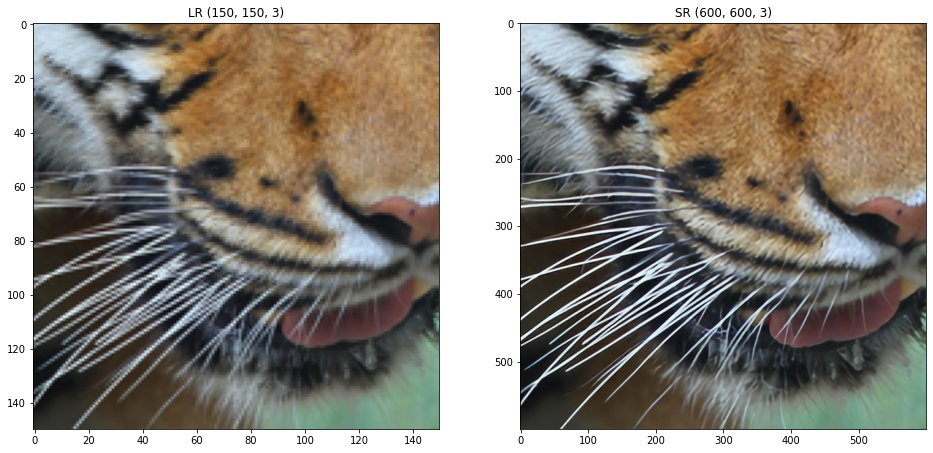

In [20]:
lr = load_img("../input/div2k-bicubic-x4/DIV2K_train_LR_bicubic/X4/0010x4.png")
lr = tf.image.random_crop(lr, (150,150,3))
pred = Predict(edsr, lr)

plt.figure(figsize=(16,9))
plt.subplot(121), plt.imshow(lr), plt.title(f"LR {lr.shape}")
plt.subplot(122), plt.imshow(pred), plt.title(f"SR {pred.shape}")
plt.show()

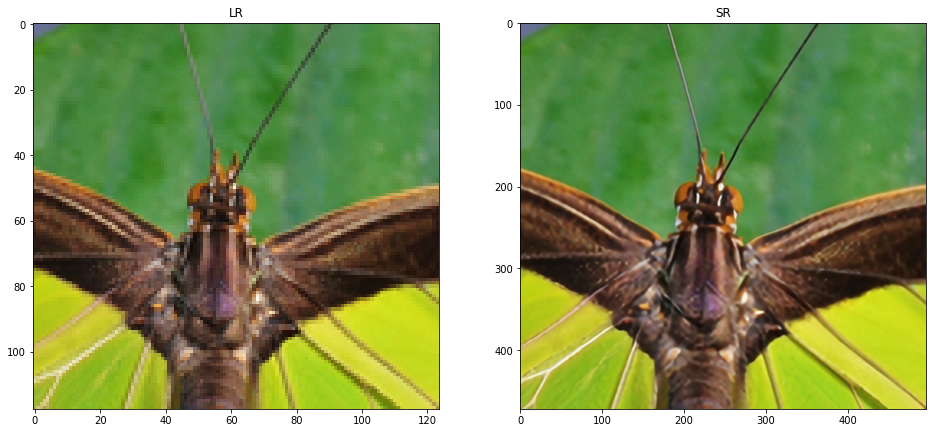

In [21]:
lr = load_img("../input/cat-and-bug/bug.png")
pred = Predict(edsr, lr)

plt.figure(figsize=(16,9))
plt.subplot(121), plt.imshow(lr), plt.title("LR")
plt.subplot(122), plt.imshow(pred), plt.title("SR")
plt.show()

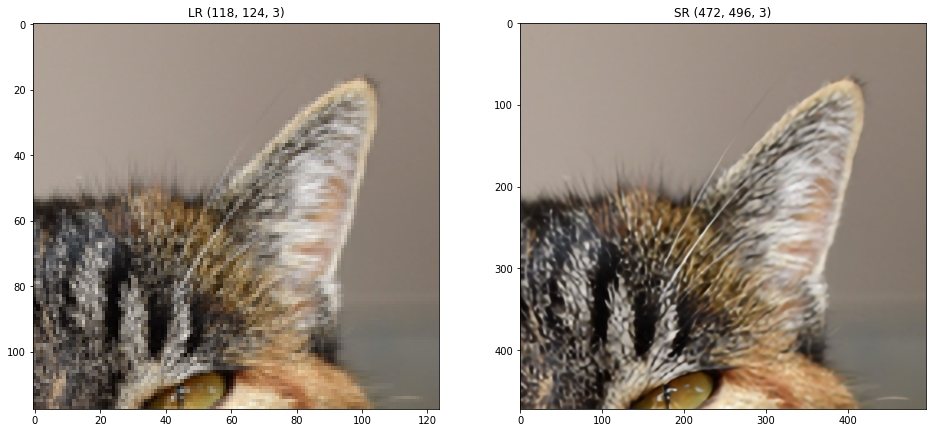

In [22]:
lr = load_img("../input/cat-and-bug/cat.png")
pred = Predict(edsr, lr)

plt.figure(figsize=(16,9))
plt.subplot(121), plt.imshow(lr), plt.title(f"LR {lr.shape}")
plt.subplot(122), plt.imshow(pred), plt.title(f"SR {pred.shape}")
plt.show()

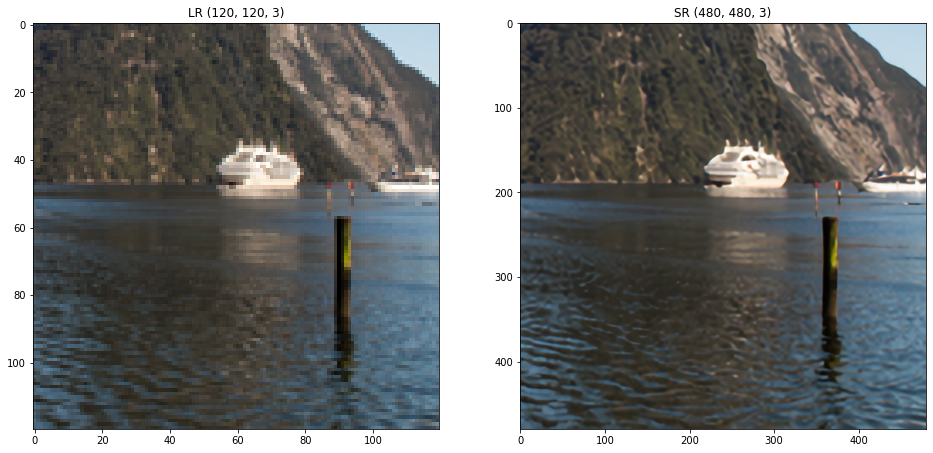

In [23]:
lr = load_img("../input/div2k-bicubic-x4/DIV2K_train_LR_bicubic/X4/0039x4.png")
lr = tf.image.random_crop(lr, (120,120,3))
pred = Predict(edsr, lr)

plt.figure(figsize=(16,9))
plt.subplot(121), plt.imshow(lr), plt.title(f"LR {lr.shape}")
plt.subplot(122), plt.imshow(pred), plt.title(f"SR {pred.shape}")
plt.show()

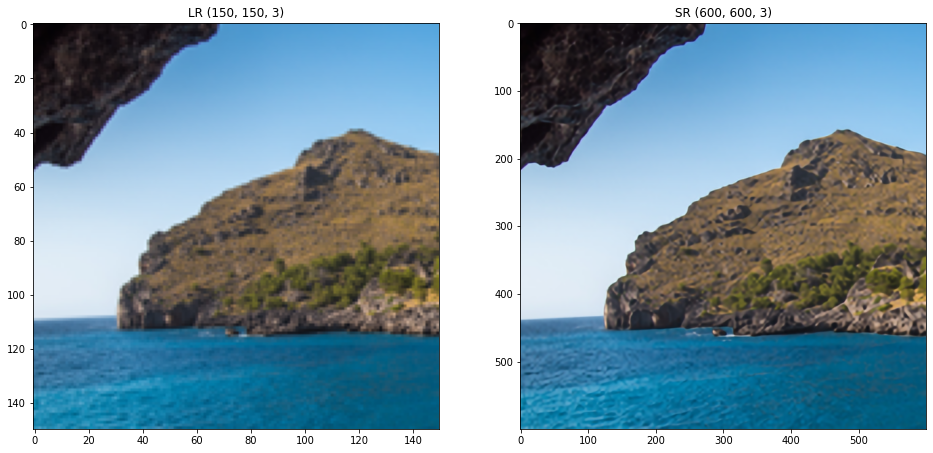

In [24]:
lr = load_img("../input/div2k-bicubic-x4/DIV2K_train_LR_bicubic/X4/0051x4.png")
lr = tf.image.random_crop(lr, (150,150,3))
pred = Predict(edsr, lr)

plt.figure(figsize=(16,9))
plt.subplot(121), plt.imshow(lr), plt.title(f"LR {lr.shape}")
plt.subplot(122), plt.imshow(pred), plt.title(f"SR {pred.shape}")
plt.show()

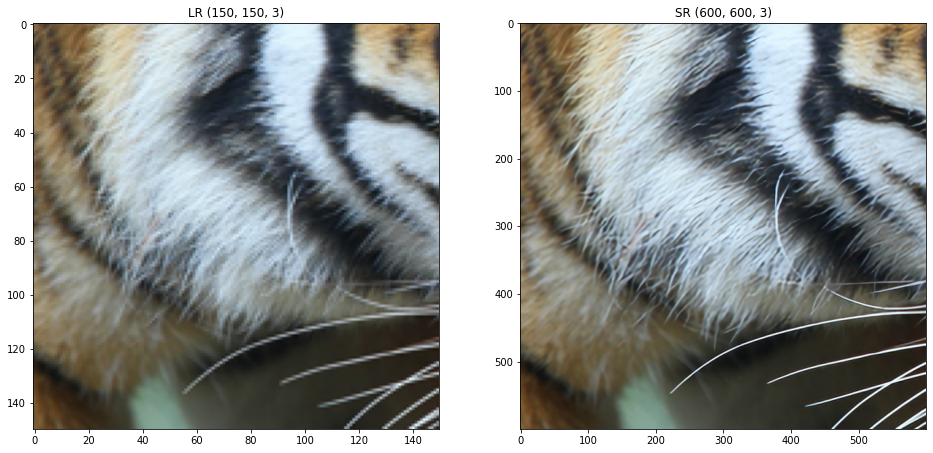

In [25]:
lr = load_img("../input/div2k-bicubic-x4/DIV2K_train_LR_bicubic/X4/0010x4.png")
lr = tf.image.random_crop(lr, (150,150,3))
pred = Predict(edsr, lr)

plt.figure(figsize=(16,9))
plt.subplot(121), plt.imshow(lr), plt.title(f"LR {lr.shape}")
plt.subplot(122), plt.imshow(pred), plt.title(f"SR {pred.shape}")
plt.show()

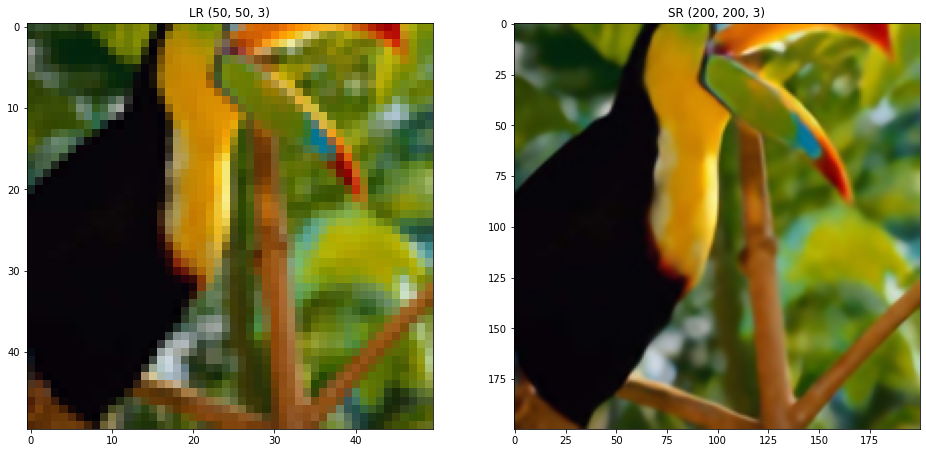

In [26]:
lr = load_img("../input/set5-hr-lr/Set5/LR/bicubic/x4/bird.png")
lr = tf.image.random_crop(lr, (50,50,3))
pred = Predict(edsr, lr)

plt.figure(figsize=(16,9))
plt.subplot(121), plt.imshow(lr), plt.title(f"LR {lr.shape}")
plt.subplot(122), plt.imshow(pred), plt.title(f"SR {pred.shape}")
plt.show()